# Representation of media outlets on Reddit

This notebook analyzes which media outlets are most prominently featured
on the main German-language subreddit "[/de](https://www.reddit.com/r/de)."


The main results of this analysis are as follows:
- More than half of all posts to the "/de" subreddit are links to external websites.
- **spiegel.de** is the website with the most submissions, closely followed by **sueddeutsche.de**.
- The highest scoring submissions to this subreddit are links to images, but the most-discussed submissions
  are those that link to media sources.
- The engagement a submission produces in terms of the number of comments depends strongly on the news source: the median submission to tagesspiegel.de, n-tv.de, or spiegel.de generates around 30 comments, while submissions to taz.de or sueddeutsche.de receive only about 10 comments.

Contents:
- [Data preparation](#prep)
- [Data overview](#data_overview)
- [Sources of submissions](#sources)
- [Engagement: Score and number of comments](#engagement)





## Data preparation <a class="anchor" id="prep"></a>

### Imports

In [1]:
from urllib.parse import urlparse
import pickle
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from plotnine import *
import arrow

# helper class to download and update Reddit submissions
import SubmissionDownloader

DOWNLOAD = False # whether to re-download the data

# plots
#%config InlineBackend.figure_format = 'svg'
my_theme = theme_bw() + theme(text=element_text(family="Arial"))

### Download data

The Reddit API does not allow the collection of historical data, such as the daily submissions to a subreddit. I therefore use the Pushshift API to download all submissions to the /de subreddit in 2021. The submissions are collected in the Pushshift database at the time of posting, so the scores (as well as possible edits) are not captured by the database. In a second step, I use the official reddit API to update all submissions such that they have the most recents scores.

If you want to download the data yourself, you need to set up a [`praw.ini` file](https://praw.readthedocs.io/en/stable/getting_started/configuration/prawini.html) with a `client_id` and `client_secret`, and set variable `DOWNLOAD` above to `True`. The following two steps can take a couple of hours. The requests to the Pushshift API are cached. For the Reddit API, caching seems to be more difficult due to the authentification process.

In [2]:
if DOWNLOAD:
    sd = SubmissionDownloader.SubmissionDownloader('pushshift_cache')
    # download all submission via the Pushshift API
    submissions = sd.get_subreddit_submissions(
        subreddit = 'de',
        start = arrow.get('2021-01-01T00:00:00.000+01:00'),
        end = arrow.get('2021-12-31T23:59:59.000+01:00'), wait_time = 0.2)
    # update attributes with most recent data from the Reddit API
    submissions = sd.update_subreddit_submissions(submissions,
        attributes = ['score', 'upvote_ratio', 'removed_by_category', 'num_comments'])
    # save result
    with open('submissions.pickle', 'wb') as f:
        pickle.dump(submissions, f, pickle.HIGHEST_PROTOCOL)
else:
    # load saved file
    with open('submissions.pickle', 'rb') as f:
        submissions = pickle.load(f)

### Clean data

This code turns the data set into a DataFrame and does some light cleaning. 
All submissions that were deleted by Reddit or the moderators are also removed from the dataset.

In [3]:
df = pd.DataFrame(submissions)
df['datetime'] = pd.to_datetime(df['created_utc'], unit='s', utc=True).dt.tz_convert('Europe/Berlin')
df = df[df['datetime'].dt.year == 2021]
# only retain posts that were not removed by Reddit, moderators, etc.
df = df[df['removed_by_category'].isnull()]
# only retain subset of data
df = df[['id', 'datetime', 'author', 'title', 'url', 'score', 'num_comments', 'full_link']]
# helper columns
df['N'] = 1
df['day'] = pd.to_datetime(df['datetime'].dt.date)
df['week'] = df['datetime'].dt.isocalendar().week.astype(int)
# get domain from URLs
def remove_prefixes(str, prefixes):
    for prefix in prefixes:
        str = str.removeprefix(prefix)
    return str

parse_url = lambda url: remove_prefixes(urlparse(url).netloc, ['www.', 'www1.', 'i.', 'v.', '1.'])
df['domain'] = df['url'].apply(parse_url)
# recode domains
df['domain'] = df['domain'].replace({
    'redd.it': 'reddit.com',
    '': 'reddit.com',
    'youtu.be': 'youtube.com',
    'sz.de': 'sueddeutsche.de',
    'sz-magazin.sueddeutsche.de': 'sueddeutsche.de'
})

df.shape

(34239, 12)

The final dataset contains 34,239 submissions.

## Data overview <a class="anchor" id="data_overview"></a>

The following figures shows the daily number of submissions to the /de subreddit. 
Noticeably, a number of days early in the year appear to have zero submissions. This is due to 
a current problem with the Pushshift API that will hopefully be fixed by a future update. Overall, there are 18 days with missing data.

The number of submissions is roughly stable at about 100 throughout the year, with a noticeable 
spike around the Federal Election in September, and a decrease of activity in November and December.

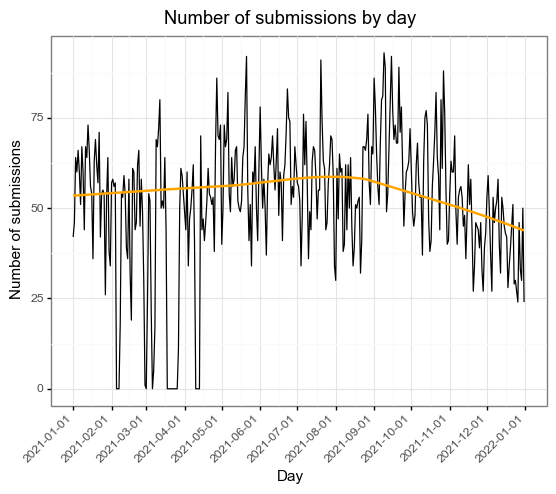

<ggplot: (719535092)>

In [14]:
by_day = df.resample('D', on = 'datetime')['N'].count().reset_index()

ggplot(by_day, aes('datetime', 'N')) + \
    geom_line() + \
    geom_smooth(data=by_day[by_day['N'] > 0], color='orange', se=False) + \
    scale_x_date(date_breaks='1 month') + \
    labs(title="Number of submissions by day", x="Day", y="Number of submissions") + \
    my_theme + \
    theme(axis_text_x=element_text(rotation=45, hjust=1))

As the following table shows, out of the 347 days with non-zero submissions, the average number of submissions is about 100, with a minimum of 4 (probably also a Pushshift API problem), and a maximum of 176.

In [5]:
by_day.query('N>0')['N'].describe().round(2).reset_index()

,index,N
0,count,347.00
1,mean,98.67
2,std,22.72
3,min,4.00
4,25%,86.00
5,50%,99.00
6,75%,111.50
7,max,176.00


## Sources of submissions <a class="anchor" id="sources"></a>

The first interesting question regards the number of submissions from different websites. 
This first table shows that posts to other sites on Reddit and text posts that don't link
directly to another site comprise about 45% of submission. The remaining 55% of submissions
are links to other domains, such as spiegel.de or sueddeutsche.de.

In [6]:
def counts_table(by):
    tab = df.groupby('domain')['N'].count().reset_index()
    tab.sort_values('N', ascending=False, inplace=True)
    tab['%'] = 100 * tab['N'] / tab['N'].sum()
    tab['Cumul. %'] = tab['%'].cumsum()
    return tab[['domain', 'N', '%', 'Cumul. %']]

counts_table('domain').head(5).round(1)

,domain,N,%,Cumul. %
928,reddit.com,15246,44.5,44.5
1020,spiegel.de,1791,5.2,49.8
1059,sueddeutsche.de,1688,4.9,54.7
1255,youtube.com,1280,3.7,58.4
1080,tagesschau.de,1168,3.4,61.8


For the remainder of the analysis, I'll restrict attention to submissions that are links
to external websites.
The following table shows the distribution of domains, ordered by popularity. Although there
are over 1,200 unique domains in the dataset, submissions to the 10 top domains account for
more than half of all submissions. 
Besides youtube.com (video content) and imgur.com (image content), the remaining websites
are all 'traditional' news outlets.

In [7]:
df = df[df['domain'] != 'reddit.com']
print("# of unique domains: ", len(df['domain'].unique()))
counts_table('domain').head(20).round(1)

# of unique domains:  1275


,domain,N,%,Cumul. %
1019,spiegel.de,1791,9.4,9.4
1058,sueddeutsche.de,1688,8.9,18.3
1254,youtube.com,1280,6.7,25.1
1079,tagesschau.de,1168,6.1,31.2
1260,zeit.de,791,4.2,35.4
554,imgur.com,764,4.0,39.4
520,heise.de,675,3.6,42.9
1080,tagesspiegel.de,629,3.3,46.3
289,derstandard.at,587,3.1,49.3
1087,taz.de,533,2.8,52.2


The following plot shows the popularity of the different outlets throughout the year.
The plot shows how many of the weekly submissions are accounted for by the four most 
popular news sources. Although the data is rather noisy, the trends cautiously
indicates a stable trajectory for spiegel.de and zeit.de, while sueddeutsche.de
decreased somewhat. The trajectory for tagesschau.de, on the other hand, is on
the upswing.

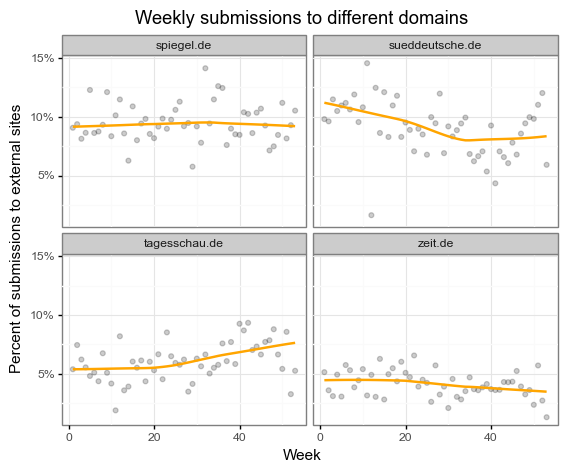

In [8]:
by_week_domain = df.groupby(['domain', 'week'])['N'].count().reset_index()
by_week_domain['N_by_week'] = by_week_domain.groupby('week')['N'].transform('sum')
by_week_domain['%'] = by_week_domain['N'] / by_week_domain['N_by_week']

subset = ['spiegel.de', 'sueddeutsche.de', 'tagesschau.de', 'zeit.de']

ggplot(by_week_domain[by_week_domain['domain'].isin(subset)], aes('week', '%')) + \
    facet_wrap('domain') + \
    geom_point(alpha=0.2) + \
    scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]) + \
    geom_smooth(color='orange', se=False) + \
    labs(x='Week', y='Percent of submissions to external sites', 
         title='Weekly submissions to different domains') + \
    my_theme

## Engagement: Score and number of comments <a class="anchor" id="engagement"></a>

Users on Reddit can upvote and downvote submissions, resulting in a 'score' for each submission. 
This is used by Reddit to display the most interesting submissions first. Users can also comment
on submissions, and the dataset contains the number of comments a submission has generated.

The median submission generates a score of 31, with 18 comments. 50% of submissions have a score
between 7 and 108, and between 6 and 53 comments.

In [9]:
desc = lambda col: df[col].describe().reset_index().round(1)
pd.concat(map(desc, ['score', 'num_comments']), axis=1)

,index,score,index,num_comments
0,count,18993.0,count,18993.0
1,mean,146.1,mean,51.9
2,std,484.6,std,98.5
3,min,0.0,min,0.0
4,25%,7.0,25%,6.0
5,50%,31.0,50%,18.0
6,75%,108.0,75%,53.0
7,max,11960.0,max,2162.0


The correlation between the score and the number of comments is 0.53. The fact that this correlation
is not perfect can be seen by inspecting the submissions with the highest score, and separately
the submissions with the highest number of comments. As seen below, these distributions are quite dissimilar.
All of the 10 most highly voted submission are links to images (imgur.com/Facebook), but most of
the most-discussed submissions are links to news stories.

In [10]:
cols = ['datetime', 'domain', 'score']
df.sort_values('score', ascending=False)[cols].iloc[:10].style.hide_index()

datetime,domain,score
2021-03-11 07:46:29+01:00,imgur.com,11960
2021-05-19 10:16:32+02:00,scontent-muc2-1.xx.fbcdn.net,11275
2021-02-09 11:57:44+01:00,imgur.com,11104
2021-07-21 13:43:16+02:00,imgur.com,9977
2021-01-17 10:22:22+01:00,imgur.com,9588
2021-06-18 11:01:46+02:00,imgur.com,9525
2021-04-23 09:49:50+02:00,imgur.com,9065
2021-08-29 10:10:15+02:00,scontent-frt3-1.xx.fbcdn.net,8928
2021-04-26 16:21:40+02:00,imgur.com,8464
2021-08-19 12:29:41+02:00,imgur.com,8218


In [11]:
cols = ['datetime', 'domain', 'title', 'num_comments']
df.sort_values('num_comments', ascending=False)[cols].iloc[:10].style.hide_index()

datetime,domain,title,num_comments
2021-02-26 08:20:34+01:00,rnd.de,"""Diese kleinen Pisser"": Bayern-3-Moderator beleidigt koreanische Pop-Band und löst Rassismus-Eklat aus",2162
2021-04-15 09:21:19+02:00,businessinsider.de,Berliner Mietendeckel: Bundesverfassungsgericht kippt umstrittenes Gesetz,1708
2021-12-06 09:50:04+01:00,spiegel.de,SPD gibt Ministerien bekannt: Karl Lauterbach wird Gesundheitsminister,1612
2021-07-22 07:55:51+02:00,imgur.com,Kulturschock des Tages - So macht man im Osten Jägerschnitzel..?,1413
2021-10-20 06:54:17+02:00,t3n.de,Krypto-Kraftwerk produziert Bitcoin für 45 Millionen Dollar statt Strom für Zehntausende.,1297
2021-11-19 19:55:57+01:00,derstandard.at,Tote bei Black-Lives-Matter-Protest: Kyle Rittenhouse freigesprochen - USA,1273
2021-01-16 11:29:49+01:00,tagesschau.de,Armin Laschet gewinnt Wahl um CDU-Vorsitz,1164
2021-10-10 19:35:21+02:00,berliner-zeitung.de,Rassismus-Vorwurf: Grünen-Sprecherin Sarah-Lee Heinrich bereut Tweets,1154
2021-05-04 14:04:52+02:00,tagesschau.de,Rechte von Geimpften und Genesenen: Bundeskabinett bringt Lockerungen auf den Weg,1149
2021-04-04 12:04:14+02:00,imgur.com,Neue Gesetze für Haas und Beleidigung im Netz seit gestern (03.04.2021) in Kraft,1078


Looking at the most prominent domains in terms of number of submissions, I now study the 
score and the number of comments the median submission generates. Interestingly, there is
wide variation for both of these outcomes across domains. For instance, the median submission
to tagesspiegel.de, n-tv.de, or spiegel.de generates around 30 comments and a score of about 50.
However, submissions to taz.de or sueddeutsche.de receive only about 10 comments, and a score
of about 10.

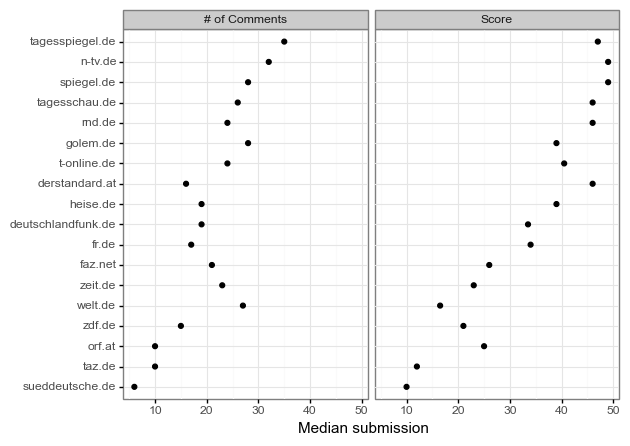

In [12]:
by_domain = df.groupby(['domain']).\
    agg({ 'N': 'count', 'score': 'median', 'num_comments': 'median'}).\
    reset_index().\
    sort_values('N', ascending=False).\
    drop('N', axis=1).\
    head(20).\
    query('domain != "imgur.com" & domain != "youtube.com"').\
    melt(id_vars=['domain']).\
    replace({'variable': {'num_comments': '# of Comments', 'score': 'Score'}})

ggplot(by_domain, aes(y='reorder(domain, value)', x='value')) + \
    facet_wrap('variable') + \
    geom_point() + \
    labs(x='Median submission', y='') + \
    my_theme

A final plot breaks down the median score across different media outlets by week. 
Over the year, median scores for spiegel.de and tageschau.de are slightly increasing. 
Again, we see that submissions to sueddeutsche.de generate few comments, despite
this being the second most-submitted news site on the subreddit.

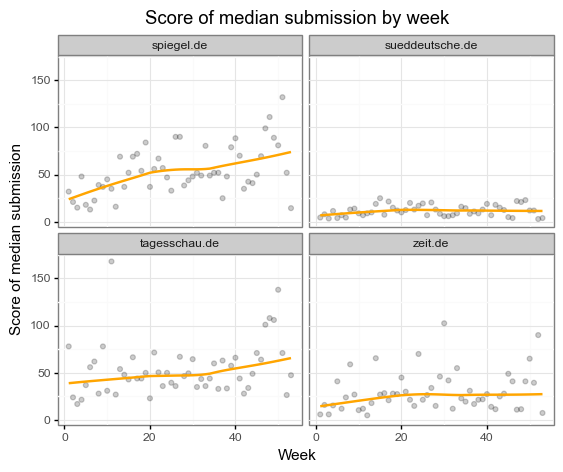

<ggplot: (719586922)>

In [15]:
by_week_domain = df.groupby(['domain', 'week'])['score'].median().reset_index()

ggplot(by_week_domain[by_week_domain['domain'].isin(subset)], aes('week', 'score')) + \
    facet_wrap('domain') + \
    geom_point(alpha=0.2) + \
    geom_smooth(color='orange', se=False) + \
    labs(x='Week', y='Score of median submission', 
         title='Score of median submission by week') + \
    my_theme